# Font Classification with PyTorch and ResNet18
In this notebook, we will use the PyTorch deep learning framework to train a ResNet18 model to classify fonts. We will use the `torchvision` library to load the dataset and the `sklearn` library to evaluate the model using accuracy, precision, recall, F1-score, and the ROC curve. We will also visualize the confusion matrix to understand the model's performance on each class.

Imports

In [10]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import time

Choose a model

In [11]:
model_name = 'resnet18'
print(f'Using model: {model_name}')

Using model: resnet18


Load and prepare the dataset

In [12]:
image_height = 32
image_width = 150
train_size_perc = 0.7

# Set the seed for reproducibility
torch.manual_seed(0)

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize images to a fixed size
    transforms.ToTensor(),                           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5],      # Normalize pixel values
                         std=[0.5, 0.5, 0.5])])

# Specify the path to your dataset
data_dir = '../fonts'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define the sizes of the training, validation, and test sets
train_size = int(train_size_perc * len(dataset))  # 70% of the dataset for training
val_size = int(((1.0 - train_size_perc)/2) * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for test (15%)

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

batch_size = int(train_size * 0.01)

# Create data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Calculate the size of the dataset
num_images = len(dataset)
num_batches = len(train_loader)
print(f'Number of images: {num_images}')
print(f'Number of batches: {num_batches}')
print(f'Batch size: {batch_size}')
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

# Get the class names
class_names = dataset.classes
print(f'Class names: {class_names}')

Number of images: 15000
Number of batches: 100
Batch size: 105
Number of training images: 10500
Number of validation images: 2250
Number of test images: 2250
Class names: ['Algerian', 'Arial', 'Baskerville', 'Calibry', 'Calligraphy', 'Cambria', 'Comic Sans MS', 'Courier', 'Elephant', 'Fascinate', 'Georgia', 'Helvetica', 'Lucida Bright', 'Nasalization', 'Times New Roman']


Load the model

In [13]:
from sys import platform

# Load the model
model = models.__dict__[model_name](weights=None)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Move model to the device (CPU or GPU)
if platform != "win32":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Model moved to {device}')

Model moved to mps


Train the model

Epoch 1
-------------------------------
Training - Epoch [1/40], Step [10/100], Loss: 1.5077
Training - Epoch [1/40], Step [20/100], Loss: 0.8897
Training - Epoch [1/40], Step [30/100], Loss: 0.5380
Training - Epoch [1/40], Step [40/100], Loss: 0.3409
Training - Epoch [1/40], Step [50/100], Loss: 0.3299
Training - Epoch [1/40], Step [60/100], Loss: 0.4474
Training - Epoch [1/40], Step [70/100], Loss: 0.3824
Training - Epoch [1/40], Step [80/100], Loss: 0.2659
Training - Epoch [1/40], Step [90/100], Loss: 0.1982
Training - Epoch [1/40], Step [100/100], Loss: 0.0927
Validation - Epoch [1/40], Loss: 0.8194, Accuracy: 0.7760
Model saved as resnet18_font_classifier.pth
Epoch 2
-------------------------------
Training - Epoch [2/40], Step [10/100], Loss: 0.1843
Training - Epoch [2/40], Step [20/100], Loss: 0.1394
Training - Epoch [2/40], Step [30/100], Loss: 0.3420
Training - Epoch [2/40], Step [40/100], Loss: 0.1840
Training - Epoch [2/40], Step [50/100], Loss: 0.2690
Training - Epoch [2/40

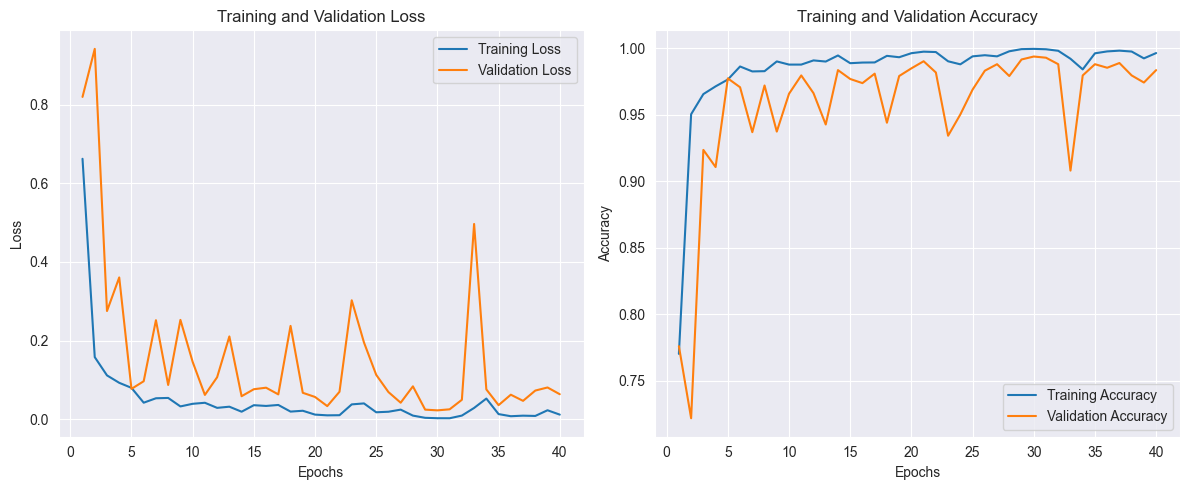

Finished Training
Time taken for training: 1287.03 seconds
Medium time per epoch: 32.18 seconds


In [14]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40
best_val_loss = float('inf')

# Lists to store training and validation metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set the model to training mode
model.train()

start_time = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print training statistics
        if (i + 1) % 10 == 0:
            print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation statistics
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../models/' + f'{model_name}_font_classifier.pth')
        print(f'Model saved as {model_name}_font_classifier.pth')

end_time = time.time()

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training')

# Print the time taken for training
print(f'Time taken for training: {end_time - start_time:.2f} seconds')
## Print medium time per epoch
print(f'Medium time per epoch: {(end_time - start_time)/num_epochs:.2f} seconds')

In [15]:
# Load the model
model_path = '../models/' + f'{model_name}_font_classifier.pth'
model = models.__dict__[model_name](weights=None)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(f'Model loaded from {model_path}')

Model loaded from ../models/resnet18_font_classifier.pth


Evaluate the model

Accuracy: 99.07%
Precision: 0.99
Recall: 0.99
F1-score: 0.99
Confusion Matrix:


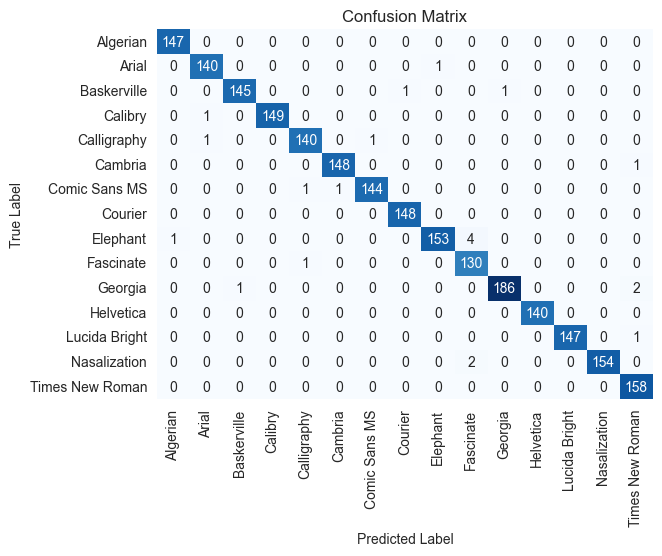

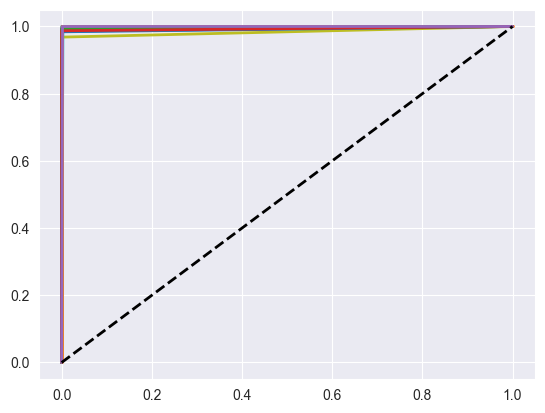

In [16]:
# Set the model to evaluation mode
model.eval()

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Perform inference
        outputs = model(images)
        
        # Compute predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Append true and predicted labels to lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: {:.2f}%'.format(100 * accuracy))

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print('Precision: {:.2f}'.format(precision))

# Compute recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print('Recall: {:.2f}'.format(recall))

# Compute F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print('F1-score: {:.2f}'.format(f1))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f'Confusion Matrix:')
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute the ROC curve
# Binarize the true labels
true_labels_binarized = label_binarize(true_labels, classes=range(len(class_names)))

# Binarize the predicted labels
predicted_labels_binarized = label_binarize(predicted_labels, classes=range(len(class_names)))

# Compute the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_labels_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot the ROC curve
plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)